# Introduction to Time Series Queries and Exploration
In this notebook we will be transforming and exploring time-series data from Onboard API. Make sure to run the following chunk of code first in order to install it.

Here we will look at how to query time-series data from building points (sensors), and how to process and visually explore them. The original version of this notebook is outlined in several YouTube videos that discuss:
- how [to load and filter time-series data](https://youtu.be/KDThdyes8kc) from sensors
- [resample and transform time-series data](https://youtu.be/VlQNGwiSSKM)
- and [create heat maps and boxplots of data](https://youtu.be/QMr0y9LOlr8) for exploration

Those YouTube videos will not perfectly match this notebook, but can walk you through the basic ideas presented here in a bit more detail.

# Create the client

For this notebook, you need to use the API Key with access to the `general` scope and `building:read` scope. Let's download and create the client:

In [1]:
!pip install onboard.client
from onboard.client import OnboardClient

try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
  api_key = input('please enter your api_key')

client = OnboardClient(api_key=api_key)

# Load & filter data

Below we generate a metadata file that combines sensor metadata, as well as relevant building and equipment metadata.

In [ ]:
import pandas as pd # we will manipulate and analyze data using Pandas
building_ids = [427, 428] # these are the mock example buildings everyone has access to

from onboard.client.models import PointSelector
query = PointSelector()
query.buildings = building_ids
selection = client.select_points(query)
points = selection["points"]

sensor_metadata = pd.DataFrame(client.get_points_by_ids(points))
equip_ids = list(set(sensor_metadata.equip_id.to_list())) # get only equipment from our buildings
equipment = pd.json_normalize(client.get_equipment_by_ids(equip_ids))

bdgs = pd.json_normalize(client.get_all_buildings()).query('id in @building_ids')
client.get

metadata = pd.merge(sensor_metadata, bdgs[["id", "name"]], how="left", left_on="building_id", right_on="id", suffixes=["_point", "_bdg"])
metadata = pd.merge(metadata, equipment[["id","equip_type_abbr","equip_type_name", "area_served_desc", "tags"]], how="left", left_on="equip_id", right_on="id")

metadata.drop("id", axis=1, inplace=True) # Axis=1 means drop columns. Axis=0 means drop rows

missing_data = (metadata.isna().sum()*100 / len(points) > 95)
bad_cols = missing_data[missing_data].index.to_list()
metadata.drop(bad_cols, axis=1, inplace=True)

Let's check the data types:

In [17]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4076 entries, 0 to 4075
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_point          4076 non-null   int64  
 1   building_id       4076 non-null   int64  
 2   last_updated      4076 non-null   float64
 3   first_updated     4076 non-null   float64
 4   name_point        4076 non-null   object 
 5   description       2562 non-null   object 
 6   units             2838 non-null   object 
 7   tagged_units      4076 non-null   object 
 8   raw_unit_id       4076 non-null   int64  
 9   value             4076 non-null   object 
 10  type              4076 non-null   object 
 11  point_type_id     4076 non-null   int64  
 12  measurement_id    4076 non-null   int64  
 13  datasource_hash   4076 non-null   object 
 14  topic             4076 non-null   object 
 15  equip_id          4076 non-null   int64  
 16  id_bdg            4076 non-null   int64  


In [8]:
metadata.head()

,id_point,building_id,last_updated,first_updated,name_point,description,units,tagged_units,raw_unit_id,value,...,measurement_id,datasource_hash,topic,equip_id,id_bdg,name_bdg,equip_type_abbr,equip_type_name,area_served_desc,tags
0,286720,427,1.666307e+12,1.626898e+12,m252_1,CL SPT AV,degreesFahrenheit,f,2,75.0,...,1,0c08467503f0fba496bf74d1dbe28ad3,onboard/officebldg1/device10356/analogValue/11,27069,427,Office Building,FCU,Fan Coil Unit,W111 Stack Room,[]
1,286722,427,1.666307e+12,1.626898e+12,m256_1,HTG% AV,percent,%,3,0.0,...,23,762b260e822624ad712e11e816dd6f4b,onboard/officebldg1/device10356/analogValue/18,27069,427,Office Building,FCU,Fan Coil Unit,W111 Stack Room,[]
2,286723,427,1.666307e+12,1.626898e+12,m251_1,HT SPT AV,degreesFahrenheit,f,2,70.0,...,1,4911c9e6468d48a87ce65134013b2cb0,onboard/officebldg1/device10356/analogValue/19,27069,427,Office Building,FCU,Fan Coil Unit,W111 Stack Room,[]
3,286724,427,1.666307e+12,1.626898e+12,occupied_cool_setpoint_1,None,degreesFahrenheit,f,2,75.0,...,1,c416edc27c2a95bb00c14b71b95cefb8,onboard/officebldg1/device10356/analogValue/2,27069,427,Office Building,FCU,Fan Coil Unit,W111 Stack Room,[]
4,286725,427,1.666307e+12,1.626898e+12,m250_1,RT AV,degreesFahrenheit,f,2,72.59,...,1,59a5aa16e73967af90ae1dff8b85600f,onboard/officebldg1/device10356/analogValue/23,27069,427,Office Building,FCU,Fan Coil Unit,W111 Stack Room,[]


We have a lot of points here:

In [ ]:
len(metadata.id_point)

4076

Let's filter out only the Zone Temperature sensors and that are Fan Coil Units. Zone Temperature sensors have `type_id == 77`, which you can confirm by querying the ontology, like we did in the previous notebook.

In [20]:
metadata = metadata[(metadata.point_type_id == 77) & (metadata.equip_type_name == "Fan Coil Unit")]
len(metadata.id_point)

32

# Querying time-series

Now that we have our metadata filtered it's time to get the time-series of those points. Let's import the libraries we will be using:

In [20]:
from datetime import datetime, timezone, timedelta
import pytz
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries

First, create a list with the points to query. We already filtered our dataset, so it's all the points there:

In [21]:
points = list(metadata.id_point)

Let's inspect the datetime period we are working with; we have to convert the `first_updated` and `last_updated` from unix timestamp to a datetime (like we learned in a previous notebook).

In [22]:
metadata.first_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min()

Timestamp('2021-07-21 20:04:07.444000+0000', tz='UTC')

In [23]:
metadata.last_updated.apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min()

Timestamp('2022-10-24 20:23:56.117000+0000', tz='UTC')

Ok, 2021-2022. Let's select a month's worth of data; we are using the [python library datetime](https://docs.python.org/3/library/datetime.html) to create datetime objects. Remember that all the data from the API is in UTC, you have to localize all your datetimes using [PyTZ](https://pythonhosted.org/pytz/) a library designed for that purpose.

In [24]:
# Select your timezone
tz = pytz.timezone('UTC')

# Select your date and time (time is optional)
start = datetime(2021,8,1,0,0,0).replace(tzinfo=tz)
end = datetime(2022,8,1,0,0,0).replace(tzinfo=tz)

print(f"from {start} to {end}")

from 2021-08-01 00:00:00+00:00 to 2022-08-01 00:00:00+00:00


And create the query with all the parameters. Here we are saying "for all the points in `points`, give me the readings from August 1, 2021 to August 1, 2022":

In [75]:
timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)

Time to get the data!

In [18]:
test_metadata = metadata.rename(columns = {'id_point' : 'id'}).iloc[0:10] # get a subset of only 10 sensors
points = test_metadata.id.to_list()

timeseries_query = TimeseriesQuery(point_ids = points, start = start, end = end)

# Exceute query (will return and object)
query_results = client.stream_point_timeseries(timeseries_query)

# Convert to dataframe
data = points_df_from_streaming_timeseries(query_results)

In [85]:
data

,timestamp,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
0,2021-08-01T00:00:05.750000Z,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
1,2021-08-01T00:00:10.976000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2,2021-08-01T00:00:18.900000Z,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-01T00:00:20.356000Z,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
4,2021-08-01T00:00:25.555000Z,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4997059,2022-07-31T23:59:40.273000Z,NaN,NaN,NaN,NaN,73.500000,NaN,NaN,NaN,NaN,NaN
4997060,2022-07-31T23:59:40.317000Z,NaN,NaN,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN
4997061,2022-07-31T23:59:40.535000Z,NaN,72.599998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4997062,2022-07-31T23:59:41.187000Z,72.599998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Took some time to retrieve that data, it's a big dataset. Let's save it as a csv. If we need to use it later, we won't have to query all that data from the API again:

In [30]:
# data.to_csv("zone_temp_time_series.csv", index = False)

# Resampling

Let's load the dataset we just exported just to learn one more trick:

In [3]:
data = pd.read_csv("./zone_temp_time_series.csv")

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342495 entries, 0 to 342494
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  342495 non-null  object 
 1   288153     34238 non-null   float64
 2   288859     34237 non-null   float64
 3   287714     34237 non-null   float64
 4   288612     34242 non-null   float64
 5   288623     34243 non-null   float64
 6   289575     34350 non-null   float64
 7   286898     34237 non-null   float64
 8   288847     34236 non-null   float64
 9   286805     34239 non-null   float64
 10  288982     34242 non-null   float64
dtypes: float64(10), object(1)
memory usage: 28.7+ MB


In [25]:
data

,timestamp,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
0,2021-08-01 00:00:05.750000+00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
1,2021-08-01 00:00:10.976000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2,2021-08-01 00:00:18.900000+00:00,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-01 00:00:20.356000+00:00,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
4,2021-08-01 00:00:25.555000+00:00,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
342490,2021-08-26 15:09:03.772000+00:00,NaN,NaN,77.400002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
342491,2021-08-26 15:09:05.690000+00:00,NaN,NaN,NaN,NaN,75.000000,NaN,NaN,NaN,NaN,NaN
342492,2021-08-26 15:09:25.736000+00:00,72.599998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
342493,2021-08-26 15:09:32.066000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,76.800003,NaN,NaN,NaN


The timestamp there is not a datetime object yet. We could have parsed it as date [using the parameter `parse_dates` while reading](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) the csv or we can do the following:

In [4]:
data["timestamp"] = pd.to_datetime(data['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')

In [27]:
type(data.timestamp[0])

pandas._libs.tslibs.timestamps.Timestamp

See? now it is a datetime object located in UTC timezone.

One important thing when working with time-series data is knowing how to resample it. Let's inspect our data:

In [36]:
data.head(20)

,timestamp,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
0,2021-08-01 00:00:05.750000+00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
1,2021-08-01 00:00:10.976000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2,2021-08-01 00:00:18.900000+00:00,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-01 00:00:20.356000+00:00,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
4,2021-08-01 00:00:25.555000+00:00,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-08-01 00:00:44.585000+00:00,72.900002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-08-01 00:00:48.687000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,72.599998,NaN,NaN,NaN
7,2021-08-01 00:00:57.130000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.199997,NaN
8,2021-08-01 00:00:57.395000+00:00,NaN,NaN,NaN,74.099998,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-08-01 00:00:59.103000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.400002


Looks like subsequent readings for each sensor are all a minute apart, but at inconsistent intervals. To fix this, we could downsample the readings (e.g. to one per hour, or one per day), taking the average value in that period. We can do that easily with the `resample` method. You have to specify the frequency ("D" means 1 Day), on which column you will be resampling ("timestamp") and the aggregation function ("mean"). For applying this function, it is important to have your timestamp as a datetime type, otherwise it will do it by index and won't understand the frequency.

In [37]:
data.resample('D', on="timestamp").mean()

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:00+00:00,72.859228,72.076228,75.505825,74.027930,73.316691,74.972689,72.526878,71.641234,72.343300,72.930456
2021-08-02 00:00:00+00:00,72.861965,72.120350,75.024825,73.878175,73.209053,74.411064,73.472140,71.667018,72.711931,72.962736
2021-08-03 00:00:00+00:00,72.844640,72.606634,75.321736,73.882394,73.138521,74.000000,75.032887,72.161679,73.545275,72.964436
2021-08-04 00:00:00+00:00,72.865168,72.491701,75.697328,73.887227,73.799227,74.789216,75.823840,71.906540,73.772944,72.961543
2021-08-05 00:00:00+00:00,72.830666,72.494740,75.946948,73.875455,73.919718,74.999299,75.052735,71.917602,73.398458,72.954698
...,...,...,...,...,...,...,...,...,...,...
2021-08-22 00:00:00+00:00,72.897285,73.226125,75.453604,73.888235,74.502253,75.000000,77.026244,72.896381,76.560633,74.970588
2021-08-23 00:00:00+00:00,72.899088,73.412281,75.313403,74.256491,74.381895,75.000000,76.992427,73.262386,76.828121,75.159088
2021-08-24 00:00:00+00:00,72.893258,73.539607,76.335182,74.318667,75.046839,75.898388,76.589677,73.280407,76.680478,75.357544


It works exactly the same for 1 Hour ("H" is 1 Hour):

In [38]:
data.resample('H', on="timestamp").mean()

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:00+00:00,72.861016,72.228334,76.035593,73.837288,73.336669,75.0,72.594914,71.720001,72.342375,72.964406
2021-08-01 01:00:00+00:00,72.856666,72.010169,75.885001,73.891524,73.374578,75.0,72.500000,71.515254,72.400002,72.922033
2021-08-01 02:00:00+00:00,72.871186,72.000000,75.599998,73.930000,73.498305,75.0,72.501667,71.527118,72.400002,72.941666
2021-08-01 03:00:00+00:00,72.908474,71.926668,75.480000,73.933898,73.501667,75.0,72.500000,71.460001,72.311867,72.967795
2021-08-01 04:00:00+00:00,72.895000,71.900002,75.384747,73.940679,73.494915,75.0,72.500000,71.416950,72.350850,72.950846
...,...,...,...,...,...,...,...,...,...,...
2021-08-26 11:00:00+00:00,72.940677,73.098304,76.213559,73.841666,73.562711,76.0,75.650847,72.786667,73.970001,73.986665
2021-08-26 12:00:00+00:00,72.761017,73.226666,76.305001,73.850848,73.923333,76.0,76.254238,73.111863,74.783051,74.045761
2021-08-26 13:00:00+00:00,72.860000,73.257628,76.303390,73.959322,74.166101,76.0,76.473334,73.069490,74.076666,73.391524


"H" and "D" (for "hour" and "day", respectively) are both [offset aliases. You can check all of them out here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

# Plotting

## Lineplots

We are going to explore our sensors data with some simple lineplots. We are going to use [*Seaborn*](https://seaborn.pydata.org/) which works on [*Matplotlib*](https://matplotlib.org/stable/users/index.html). Let's import them:

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# This is for the visual style, I like "ggplot"
plt.style.use('ggplot')

# This for the figure size
plt.rcParams["figure.figsize"] = (20,9)

Let's plot the raw data of our sensors.

In [40]:
# These are the sensors, one per column (first one is the timestamp)
cols = data.columns[1:]
cols

Index(['288153', '288859', '287714', '288612', '288623', '289575', '286898',
       '288847', '286805', '288982'],
      dtype='object')

In [41]:
data.head(20)

,timestamp,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
0,2021-08-01 00:00:05.750000+00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
1,2021-08-01 00:00:10.976000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2,2021-08-01 00:00:18.900000+00:00,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-01 00:00:20.356000+00:00,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
4,2021-08-01 00:00:25.555000+00:00,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2021-08-01 00:00:44.585000+00:00,72.900002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2021-08-01 00:00:48.687000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,72.599998,NaN,NaN,NaN
7,2021-08-01 00:00:57.130000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.199997,NaN
8,2021-08-01 00:00:57.395000+00:00,NaN,NaN,NaN,74.099998,NaN,NaN,NaN,NaN,NaN,NaN
9,2021-08-01 00:00:59.103000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.400002


We want to first visualize the raw data, but, as mentioned above, we can tell there's a lot of redundancy because, even though all the sensors seem to sample once a minute, different sensors have different sampling timestamps within each minute. If we want to strike a balance between making this a bit easier to work with while still using as close to "raw" data as we can get, we can resample at the approximate sampling interval we see from looking at the data (which looks to be about a minute).

In [6]:
minute_data = data.resample('1T', on="timestamp").mean() # just resampling by the approximate sampling interval to reduce the number of rows
minute_data

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:00+00:00,72.900002,72.300003,76.099998,74.099998,73.400002,75.0,72.599998,71.900002,72.199997,73.400002
2021-08-01 00:01:00+00:00,73.000000,72.300003,76.099998,74.099998,73.400002,75.0,72.699997,71.900002,72.199997,73.400002
2021-08-01 00:02:00+00:00,73.000000,72.300003,76.099998,74.099998,73.400002,75.0,72.599998,71.900002,72.300003,NaN
2021-08-01 00:03:00+00:00,73.000000,72.300003,76.099998,74.099998,73.400002,75.0,72.599998,71.900002,72.300003,73.400002
2021-08-01 00:04:00+00:00,73.000000,72.300003,76.099998,NaN,73.400002,75.0,72.699997,71.800003,NaN,73.400002
...,...,...,...,...,...,...,...,...,...,...
2021-08-26 15:05:00+00:00,73.099998,73.500000,NaN,74.000000,75.000000,76.0,76.900002,73.500000,74.400002,73.900002
2021-08-26 15:06:00+00:00,72.900002,73.500000,77.099998,74.000000,75.000000,76.0,76.800003,73.400002,74.400002,73.900002
2021-08-26 15:07:00+00:00,72.800003,73.500000,77.400002,74.000000,75.000000,76.0,76.900002,73.500000,74.400002,73.900002


Only about 36,000 rows now (10 times smaller!) after resampling. Seems a lot easier to work with.

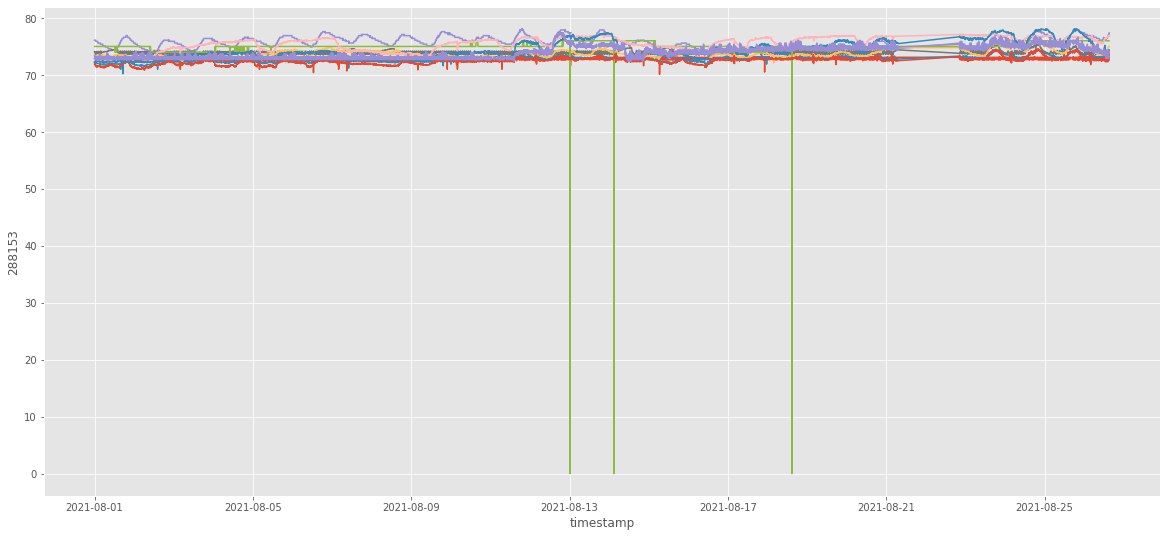

In [47]:
for col in cols:
    sns.lineplot(data=minute_data, x="timestamp", y=col)

Plot it in a slightly different way, just because there are always a million different ways to do things with pandas, and zoom in:

(68.0, 80.0)

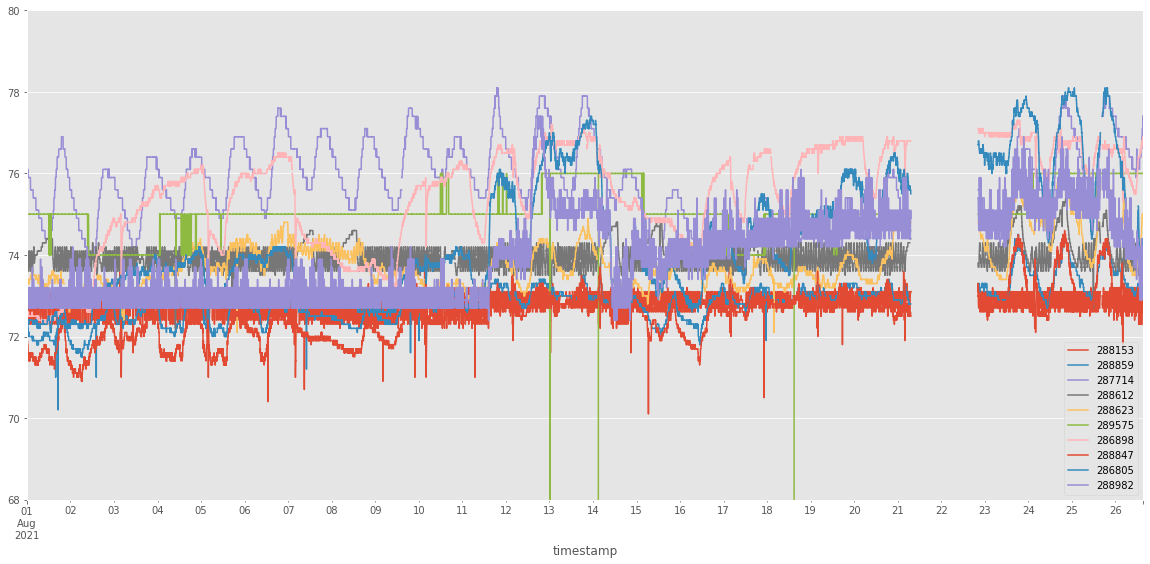

In [38]:
minute_data.plot()
plt.ylim(68,80)

In the second plot we zoomed in so we ignore those few zero values that mess with seeing the bulk of the data. Even still, this data is noisy, crowded and difficult to see.

One useful technique to deal with noisy data is to downsample to a longer interval (like an hour or a day, like we did above), so we can consider its behavior over longer time periods more smoothly.

But first, let's go deeper into our `timestamp` column. This is a datetime column, meaning that we have some functions to handle the dates better. [This pandas method](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.html) lets us access the various parts of our datetime: we can get the date, the weekday, the hour, the seconds, the minutes.

Let's try an example. This is our raw timestamp:

In [39]:
data.timestamp

0        2021-08-01 00:00:05.750000+00:00
1        2021-08-01 00:00:10.976000+00:00
2        2021-08-01 00:00:18.900000+00:00
3        2021-08-01 00:00:20.356000+00:00
4        2021-08-01 00:00:25.555000+00:00
                       ...               
342490   2021-08-26 15:09:03.772000+00:00
342491   2021-08-26 15:09:05.690000+00:00
342492   2021-08-26 15:09:25.736000+00:00
342493   2021-08-26 15:09:32.066000+00:00
342494   2021-08-26 15:09:36.197000+00:00
Name: timestamp, Length: 342495, dtype: datetime64[ns, UTC]

We can get the date:

In [40]:
data.timestamp.dt.date

0         2021-08-01
1         2021-08-01
2         2021-08-01
3         2021-08-01
4         2021-08-01
             ...    
342490    2021-08-26
342491    2021-08-26
342492    2021-08-26
342493    2021-08-26
342494    2021-08-26
Name: timestamp, Length: 342495, dtype: object

Even the day of the week (with Monday=0, Sunday=6)

In [41]:
data.timestamp.dt.weekday

0         6
1         6
2         6
3         6
4         6
         ..
342490    3
342491    3
342492    3
342493    3
342494    3
Name: timestamp, Length: 342495, dtype: int64

The hour

In [24]:
data.timestamp.dt.hour

0           0
1           0
2           0
3           0
4           0
           ..
4997059    23
4997060    23
4997061    23
4997062    23
4997063    23
Name: timestamp, Length: 4997064, dtype: int64

Or the minutes

In [25]:
data.timestamp.dt.minute

0           0
1           0
2           0
3           0
4           0
           ..
4997059    59
4997060    59
4997061    59
4997062    59
4997063    59
Name: timestamp, Length: 4997064, dtype: int64

Pretty simple! You have all the datetime information handy.

Now let's smooth the data to plot it!

In [49]:
hourly_data = data.resample('1H', on="timestamp").mean()
hourly_data.head()

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:00+00:00,72.861016,72.228334,76.035593,73.837288,73.336669,75.0,72.594914,71.720001,72.342375,72.964406
2021-08-01 01:00:00+00:00,72.856666,72.010169,75.885001,73.891524,73.374578,75.0,72.500000,71.515254,72.400002,72.922033
2021-08-01 02:00:00+00:00,72.871186,72.000000,75.599998,73.930000,73.498305,75.0,72.501667,71.527118,72.400002,72.941666
2021-08-01 03:00:00+00:00,72.908474,71.926668,75.480000,73.933898,73.501667,75.0,72.500000,71.460001,72.311867,72.967795
2021-08-01 04:00:00+00:00,72.895000,71.900002,75.384747,73.940679,73.494915,75.0,72.500000,71.416950,72.350850,72.950846


And we have the mean temperature by hour! Plotting it is simple with this data set:

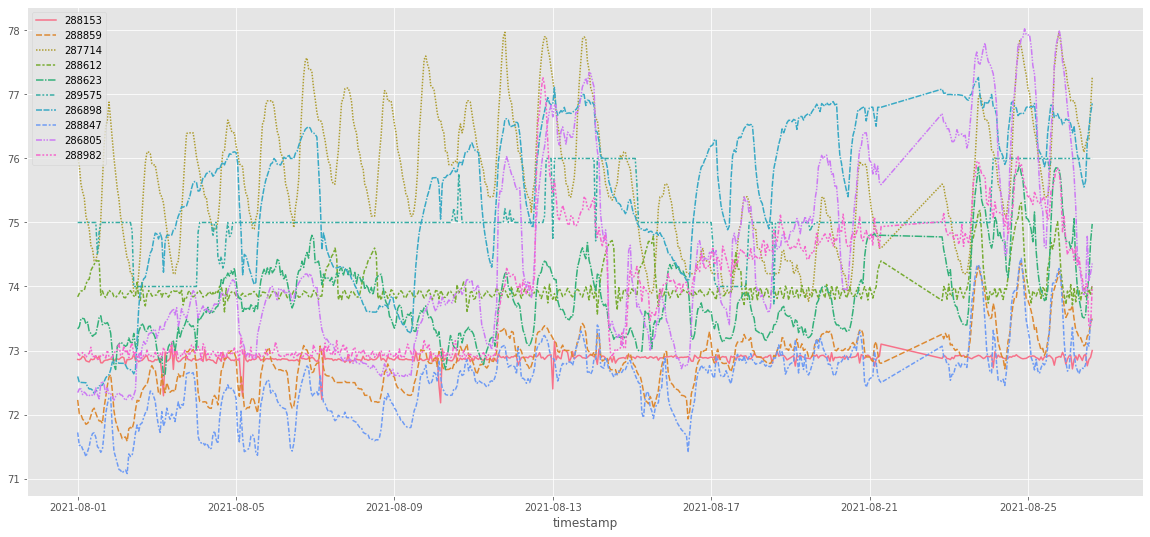

In [50]:
fig = sns.lineplot(data=hourly_data)
# plt.legend([],[], frameon=False) # if you want to hide the legend

Let's do it again but daily:

In [51]:
daily_data = data.resample('24H', on="timestamp").mean()
daily_data.head()

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
timestamp,,,,,,,,,,
2021-08-01 00:00:00+00:00,72.859228,72.076228,75.505825,74.027930,73.316691,74.972689,72.526878,71.641234,72.343300,72.930456
2021-08-02 00:00:00+00:00,72.861965,72.120350,75.024825,73.878175,73.209053,74.411064,73.472140,71.667018,72.711931,72.962736
2021-08-03 00:00:00+00:00,72.844640,72.606634,75.321736,73.882394,73.138521,74.000000,75.032887,72.161679,73.545275,72.964436
2021-08-04 00:00:00+00:00,72.865168,72.491701,75.697328,73.887227,73.799227,74.789216,75.823840,71.906540,73.772944,72.961543
2021-08-05 00:00:00+00:00,72.830666,72.494740,75.946948,73.875455,73.919718,74.999299,75.052735,71.917602,73.398458,72.954698


<AxesSubplot:xlabel='timestamp'>

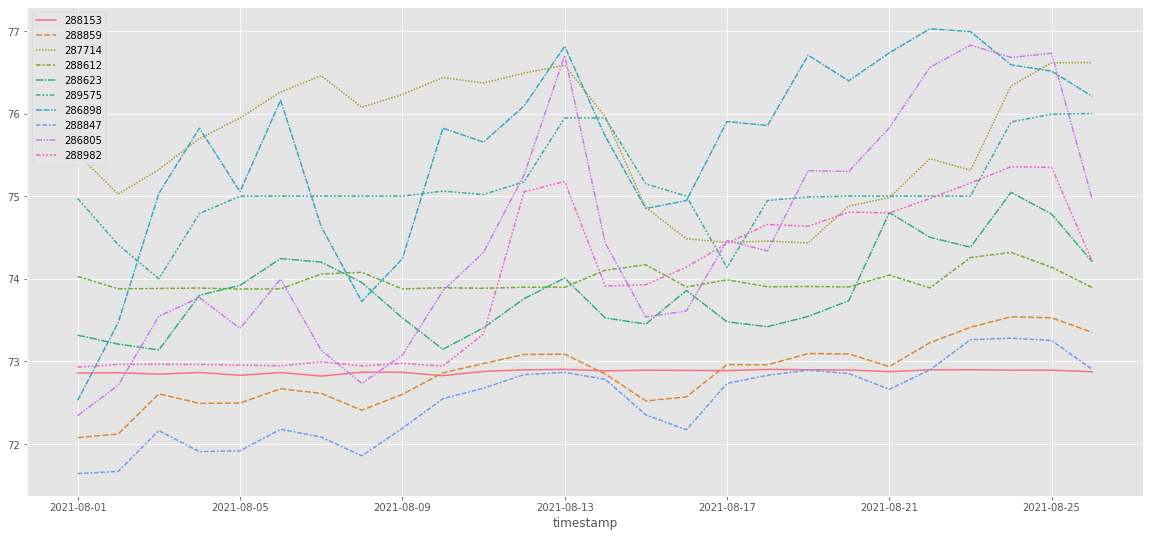

In [52]:
sns.lineplot(data=daily_data)

# This is just for hiding the legend for now, there are a lot of labels and is difficult to see the plot
# plt.legend([],[], frameon=False)

## Heatmaps

Lineplots are easy but can still be pretty diffcult to visualize. Instead, we can use [heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html), which are also really easy. Remember you can transpose your data to change the axis, like this:

In [108]:
hourly_data.T

timestamp,2021-08-01 00:00:00+00:00,2021-08-01 01:00:00+00:00,2021-08-01 02:00:00+00:00,2021-08-01 03:00:00+00:00,2021-08-01 04:00:00+00:00,2021-08-01 05:00:00+00:00,2021-08-01 06:00:00+00:00,2021-08-01 07:00:00+00:00,2021-08-01 08:00:00+00:00,2021-08-01 09:00:00+00:00,...,2022-07-31 14:00:00+00:00,2022-07-31 15:00:00+00:00,2022-07-31 16:00:00+00:00,2022-07-31 17:00:00+00:00,2022-07-31 18:00:00+00:00,2022-07-31 19:00:00+00:00,2022-07-31 20:00:00+00:00,2022-07-31 21:00:00+00:00,2022-07-31 22:00:00+00:00,2022-07-31 23:00:00+00:00
288153,72.861016,72.856666,72.871186,72.908474,72.895000,72.840678,72.828814,72.821667,72.866101,72.856666,...,72.959322,72.936667,72.862712,72.833898,72.950848,72.867797,72.803333,73.037288,72.754238,72.923333
288859,72.228334,72.010169,72.000000,71.926668,71.900002,71.847460,71.863335,71.900002,71.980000,72.069490,...,72.154999,72.354240,72.435594,72.613558,72.708331,72.779663,72.800003,72.794918,72.833336,72.735592
287714,76.035593,75.885001,75.599998,75.480000,75.384747,75.099998,75.003333,74.900002,74.639999,74.586439,...,75.140678,75.900002,75.967797,76.062711,76.099998,76.099998,76.086665,75.900002,75.844069,75.599998
288612,73.837288,73.891524,73.930000,73.933898,73.940679,74.033333,74.099998,74.113332,74.249152,74.300003,...,73.835592,73.976271,73.914998,73.793220,73.861016,73.964406,73.919999,73.862711,73.822033,73.874999
288623,73.336669,73.374578,73.498305,73.501667,73.494915,73.416950,73.445001,73.294917,73.266668,73.222032,...,73.513559,73.531666,73.486441,73.491526,73.633896,73.611665,73.559321,73.562711,73.533333,73.683051
289575,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,77.152542,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,77.118644,77.000000,77.000000
286898,72.594914,72.500000,72.501667,72.500000,72.500000,72.496610,72.432204,72.400002,72.400002,72.380002,...,72.993220,73.000000,73.128812,73.389832,73.536206,73.599998,73.654235,73.647455,73.693101,73.583050
288847,71.720001,71.515254,71.527118,71.460001,71.416950,71.341669,71.422035,71.501695,71.634998,71.703387,...,71.545764,71.871188,71.950848,72.216666,72.264408,72.352545,72.345765,72.400002,72.379663,72.184744
286805,72.342375,72.400002,72.400002,72.311867,72.350850,72.325002,72.288138,72.296670,72.311867,72.300003,...,72.494915,72.481356,72.657627,72.703447,72.647455,72.599998,72.657626,72.906781,72.736206,72.623729
288982,72.964406,72.922033,72.941666,72.967795,72.950846,72.891666,72.937288,72.956666,73.050847,72.901694,...,72.953333,72.966101,73.051723,72.962711,72.906780,72.894914,73.055931,73.122033,73.069490,72.957626


And super-easy to plot:

<AxesSubplot:xlabel='timestamp'>

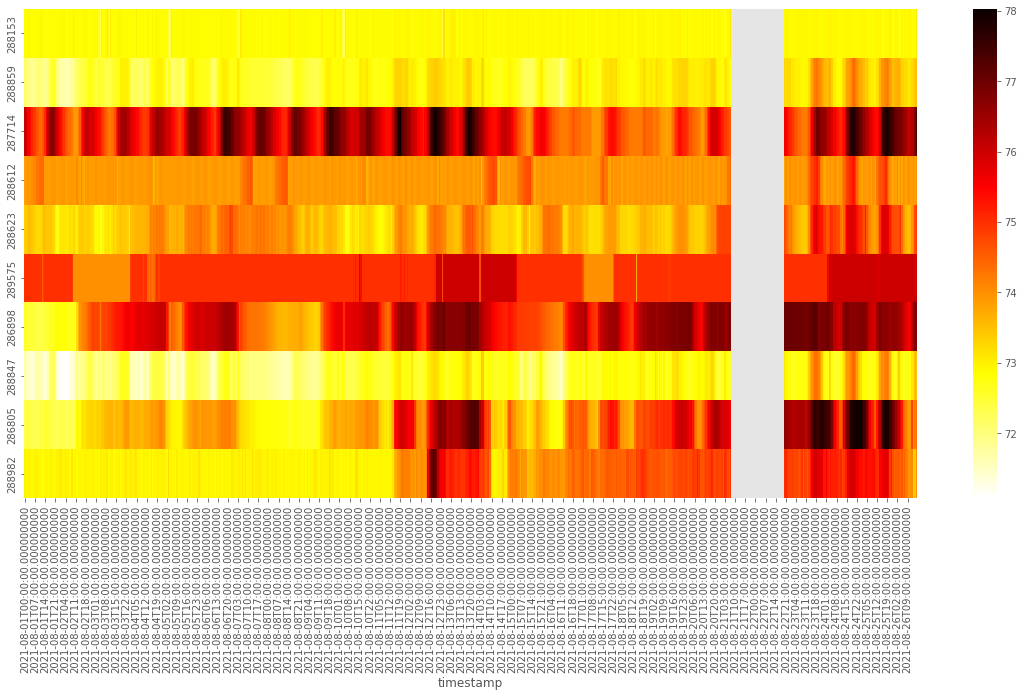

In [55]:
sns.heatmap(hourly_data.T, cmap="hot_r")

<AxesSubplot:xlabel='timestamp'>

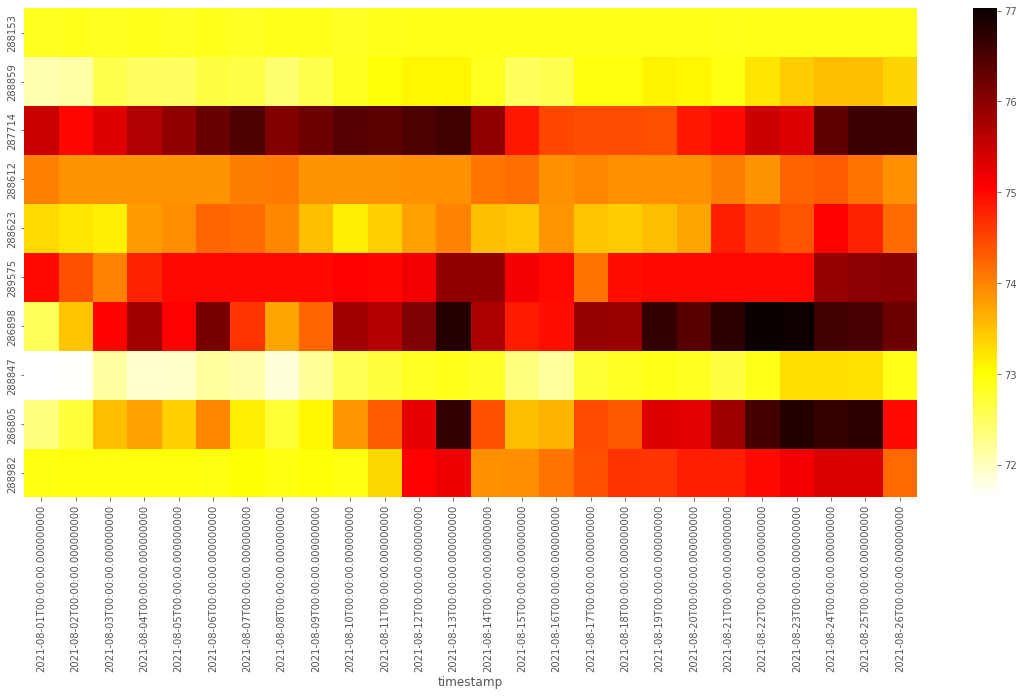

In [56]:
sns.heatmap(daily_data.T, cmap="hot_r")

With this kind of plot is pretty evident where we have gaps with no readings.

# Summary stats

Usually summary stats can help us understand our data. Fortunately, pandas has a simple method to obtain them:

In [111]:
data.describe()

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
count,505920.000000,505701.000000,505817.000000,506737.000000,506709.000000,509119.000000,473029.000000,505705.000000,473046.000000,505333.000000
mean,72.905863,72.690920,72.084442,73.950409,72.846522,70.311320,74.725144,72.465570,73.077088,73.108055
std,0.397712,0.376300,3.365999,0.317900,0.980939,4.665484,1.241294,0.460168,0.988148,0.555711
min,0.000000,0.000000,58.799999,0.000000,0.000000,0.000000,70.599998,0.000000,70.000000,71.900002
25%,72.699997,72.500000,69.000000,73.699997,72.400002,67.000000,74.099998,72.199997,72.599998,72.699997
50%,73.000000,72.699997,72.699997,74.000000,73.000000,70.000000,74.900002,72.500000,73.099998,72.900002
75%,73.099998,72.900002,75.099998,74.099998,73.500000,74.000000,75.599998,72.800003,73.599998,73.199997
max,74.199997,74.500000,78.300003,76.599998,76.099998,81.000000,77.400002,74.599998,78.099998,77.400002


These stats are often visualized in boxplots and histograms, which can be easily obtained with the plotting libraries we have been using. But first I suggest processing the dataframe a bit to be able to plot all sensors in the same figure. We are using the pandas method [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html). Currently, the data is shaped like this:

In [112]:
data.head()

,timestamp,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
0,2021-08-01 00:00:05.750000+00:00,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN
1,2021-08-01 00:00:10.976000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.900002,NaN,NaN
2,2021-08-01 00:00:18.900000+00:00,NaN,72.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-08-01 00:00:20.356000+00:00,NaN,NaN,NaN,NaN,73.400002,NaN,NaN,NaN,NaN,NaN
4,2021-08-01 00:00:25.555000+00:00,NaN,NaN,76.099998,NaN,NaN,NaN,NaN,NaN,NaN,NaN


If we use the `melt` method we can convert our columns into rows, creating a new column containing the former column names. This is a bit easier to understand by seeing the results, check it out:

In [53]:
minute_data = data.resample('1T', on="timestamp").mean() # just resampling by the approximate sampling interval to reduce the number of rows
melted_data = minute_data.reset_index().melt(id_vars="timestamp", var_name="sensor", value_name="temperature")
melted_data

,timestamp,sensor,temperature
0,2021-08-01 00:00:00+00:00,288153,72.900002
1,2021-08-01 00:01:00+00:00,288153,73.000000
2,2021-08-01 00:02:00+00:00,288153,73.000000
3,2021-08-01 00:03:00+00:00,288153,73.000000
4,2021-08-01 00:04:00+00:00,288153,73.000000
...,...,...,...
369095,2021-08-26 15:05:00+00:00,288982,73.900002
369096,2021-08-26 15:06:00+00:00,288982,73.900002
369097,2021-08-26 15:07:00+00:00,288982,73.900002
369098,2021-08-26 15:08:00+00:00,288982,73.900002


And now that we have the data in this shape, it's easy to get a boxplot:

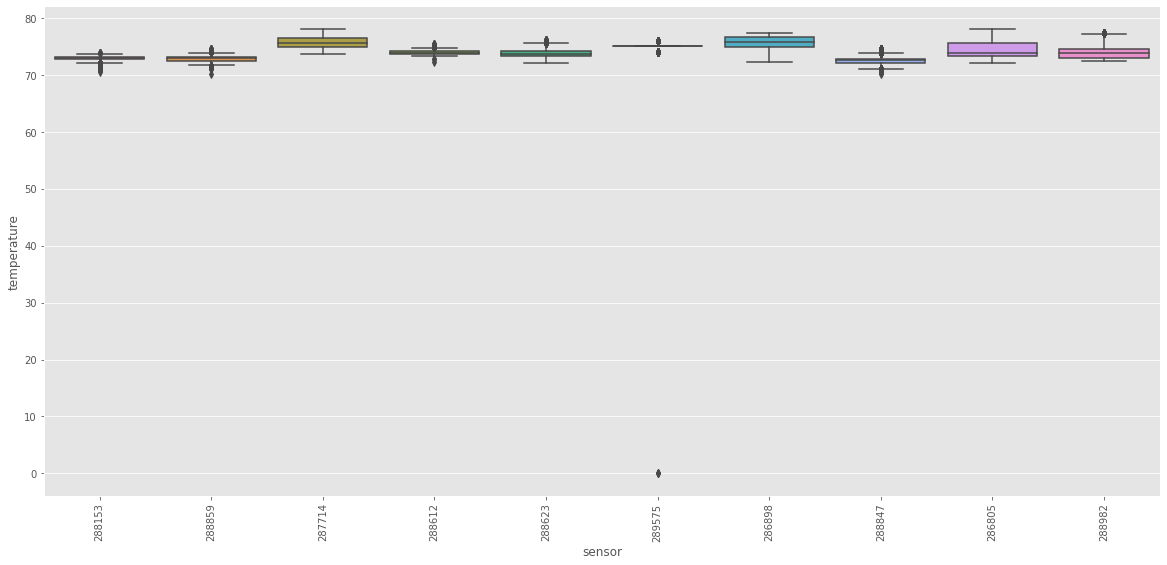

In [54]:
fig = sns.boxplot(y="temperature", x="sensor", data=melted_data)
labels = plt.xticks(rotation=90)

We can also plot a histogram, but with this many sensors a boxplot is cleaner and clearer:

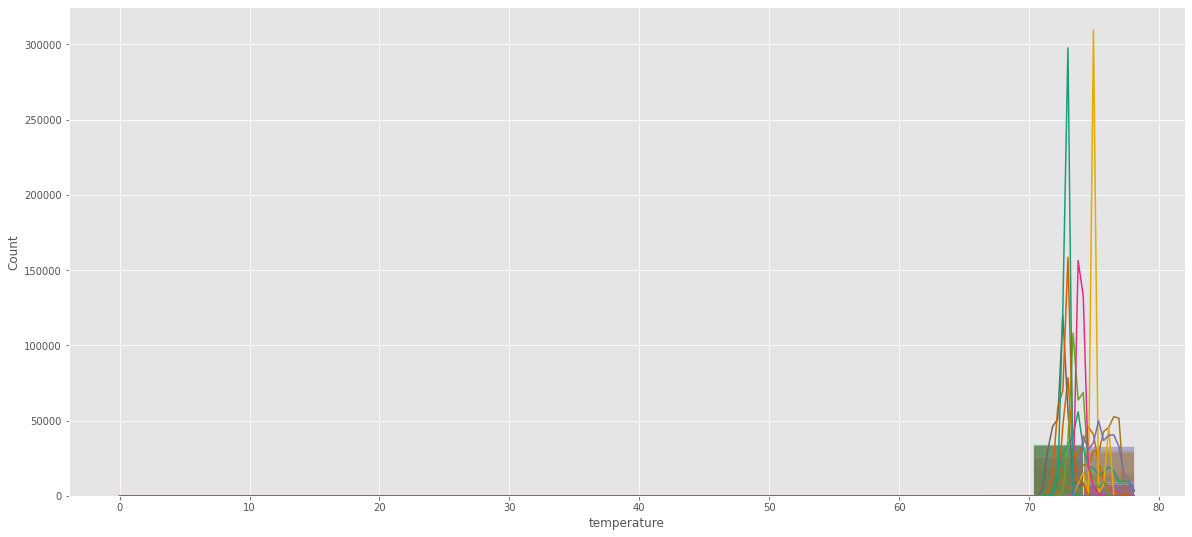

In [51]:
fig = sns.histplot(data=melted_data, x="temperature", hue="sensor", bins=20, kde=True, palette="Dark2")

# This is just for hiding the legend for now, there are a lot of labels and is difficult to see the plot
plt.legend([],[], frameon=False)

Finally, let's create a dataset with the stats. 

In [55]:
stats_data = data.describe()
stats_data

,288153,288859,287714,288612,288623,289575,286898,288847,286805,288982
count,34238.000000,34237.000000,34237.000000,34242.000000,34243.000000,34350.000000,34237.000000,34236.000000,34239.000000,34242.000000
mean,72.875045,72.826068,75.674355,73.979957,73.803382,75.086230,75.501569,72.490425,74.395286,73.915775
std,0.244790,0.479953,1.036196,0.310898,0.630309,0.894645,1.231651,0.604371,1.490616,1.040000
min,70.500000,70.199997,73.699997,72.199997,72.099998,0.000000,72.300003,70.099998,72.099998,72.400002
25%,72.699997,72.500000,74.900002,73.699997,73.300003,75.000000,74.800003,72.099998,73.300003,72.900002
50%,72.900002,72.900002,75.599998,73.900002,73.699997,75.000000,75.800003,72.599998,73.900002,73.900002
75%,73.099998,73.099998,76.400002,74.099998,74.199997,75.000000,76.599998,72.800003,75.500000,74.599998
max,73.800003,74.500000,78.099998,75.400002,76.099998,76.000000,77.300003,74.599998,78.099998,77.400002


Now transpose it and reset the index to keep a column with the point id (what was previously the column name):

In [53]:
stats_data = stats_data.T.reset_index().rename(columns={"index":"id_point"})
stats_data

,id_point,count,mean,std,min,25%,50%,75%,max
0,288153,34238.0,72.875045,0.244790,70.500000,72.699997,72.900002,73.099998,73.800003
1,288859,34237.0,72.826068,0.479953,70.199997,72.500000,72.900002,73.099998,74.500000
2,287714,34237.0,75.674355,1.036196,73.699997,74.900002,75.599998,76.400002,78.099998
3,288612,34242.0,73.979957,0.310898,72.199997,73.699997,73.900002,74.099998,75.400002
4,288623,34243.0,73.803382,0.630309,72.099998,73.300003,73.699997,74.199997,76.099998
5,289575,34350.0,75.086230,0.894645,0.000000,75.000000,75.000000,75.000000,76.000000
6,286898,34237.0,75.501569,1.231651,72.300003,74.800003,75.800003,76.599998,77.300003
7,288847,34236.0,72.490425,0.604371,70.099998,72.099998,72.599998,72.800003,74.599998
8,286805,34239.0,74.395286,1.490616,72.099998,73.300003,73.900002,75.500000,78.099998
9,288982,34242.0,73.915775,1.040000,72.400002,72.900002,73.900002,74.599998,77.400002


And now let's convert the `id_point` column in our metadata set to string (currently an int) so we can merge it with `stats_data`:

In [54]:
metadata['id_point'] = metadata['id_point'].astype(str)

And merge!

In [55]:
stats_merged = pd.merge(stats_data, metadata, how="left", on="id_point")
stats_merged.head()

,id_point,count,mean,std,min,25%,50%,75%,max,building_id,...,measurement_id,datasource_hash,topic,equip_id,id_bdg,name_bdg,equip_type_abbr,equip_type_name,area_served_desc,tags
0,288153,34238.0,72.875045,0.244790,70.500000,72.699997,72.900002,73.099998,73.800003,427,...,1,a6ce8ba9f6f2256081764d4e16756d1f,onboard/officebldg1/device3209/analogInput/1,27131,427,Office Building,FCU,Fan Coil Unit,Rm. W013,[]
1,288859,34237.0,72.826068,0.479953,70.199997,72.500000,72.900002,73.099998,74.500000,427,...,1,40bde7fc40dcd239250523020d01780e,onboard/officebldg1/device3264/analogInput/1,27130,427,Office Building,FCU,Fan Coil Unit,W-105_1,[]
2,287714,34237.0,75.674355,1.036196,73.699997,74.900002,75.599998,76.400002,78.099998,427,...,1,94bfed4f1118dbbcc3bb020c0888f823,onboard/officebldg1/device2003135/analogInput/3,27137,427,Office Building,FCU,Fan Coil Unit,Rm. WF002 Vestibule,[]
3,288612,34242.0,73.979957,0.310898,72.199997,73.699997,73.900002,74.099998,75.400002,427,...,1,c92ee11bdc14a9a848764dc7c058b29e,onboard/officebldg1/device3244/analogInput/1,27132,427,Office Building,FCU,Fan Coil Unit,RM W103 FCU 02-44,[]
4,288623,34243.0,73.803382,0.630309,72.099998,73.300003,73.699997,74.199997,76.099998,427,...,1,86c20027a20e4fd953085631ace1d2d5,onboard/officebldg1/device3245/analogInput/1,27128,427,Office Building,FCU,Fan Coil Unit,Lobby,[]


In [56]:
metadata.T

,81,170,481,644,812,823,832,844,857,1032,...,3467,3539,3633,3658,3679,3700,3724,3928,4000,4026
id_point,286805,286898,287714,288153,288612,288623,288847,288859,288982,289575,...,286085,286160,286258,286284,286306,286328,286353,286566,286641,286668
building_id,427,427,427,427,427,427,427,427,427,428,...,427,427,427,427,427,427,427,427,427,427
last_updated,1666643051936.0,1666643055933.0,1666643052861.0,1666643043724.0,1666643054945.0,1666643065154.0,1666643087762.0,1666643048764.0,1666643036117.0,1666643118358.0,...,1666643037153.0,1666643046745.0,1666643043698.0,1666643093802.0,1666643093863.0,1666643095021.0,1666643037338.0,1666643096815.0,1666643046778.0,1666643051871.0
first_updated,1626897899169.0,1626897891651.0,1626897868020.0,1626897887369.0,1626897899429.0,1626897862711.0,1626897853125.0,1626897860706.0,1626897901069.0,1626901293362.0,...,1626897855492.0,1626897899653.0,1626897866680.0,1626897886278.0,1626897861506.0,1626897854755.0,1626897847444.0,1626897905677.0,1626897884814.0,1626897892208.0
name_point,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,...,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1,zone_temp_1
description,Zone Temp,Zone Temp,Zone Temp,Zone Temperature,Zone Temperature,Zone Temperature,Zone Temperature,Zone Temperature,Zone Temp,Zone Temperature,...,Zone Temp,Zone Temp,Zone Temp,Zone Temperature,Zone Temperature,Zone Temperature,Zone Temp,Zone Temp,Zone Temp,Zone Temp
units,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,...,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit,degreesFahrenheit
tagged_units,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
raw_unit_id,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
value,73.69,73.30,74.59,73.09,73.80,73.80,73.0,73.30,72.69,71.0,...,75.30,74.40,75.90,74.30,73.19,74.30,76.09,75.90,71.80,73.09


Finally, plot! We want to visualize the mean temperature of the points, colored by the building name.

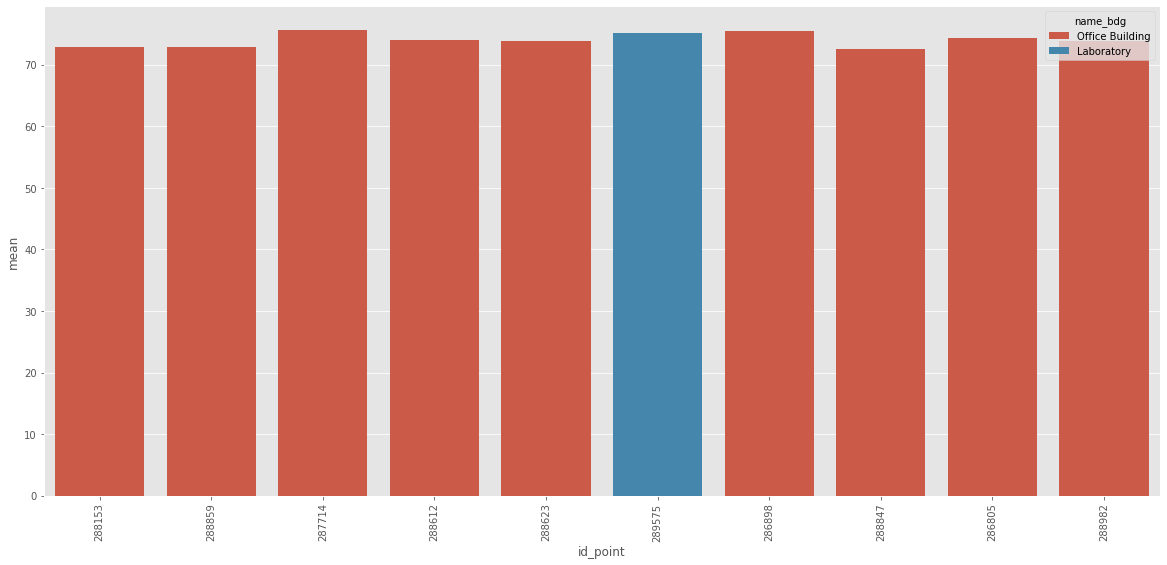

In [57]:
fig = sns.barplot(data=stats_merged, x="id_point", y="mean", hue="name_bdg", dodge=False)
labels = plt.xticks(rotation=90)